# Dense Network for IMDB classification

Take a look at this link (http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) which explains how a word2vec  is constructed out of skipgram, A word2vec is actually the weights of the neural netwrok which has been trained!! This is amazing, you are training neural network not for the results but its weights! Very nice twist. So a word2vec is the weights of the hidden layer of the ANN which tries to predict if a word is likely to occur within the vicinity of a given word. Let us say that  the total number of words is 5000 and you want a word2vec representation which is a vector of length 64. We have neural network with hidden layer containing 5000*64 

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D,SpatialDropout1D,GlobalMaxPool1D
from keras.layers import Dense,Flatten,Dropout,Embedding
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/Users/abhinav.sunderrajan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# output directory name:
output_dir = 'model_output/conv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
# the top 50 words to skip, that is the top 50 commonly occuring words
# it hoped that these words are non contextual like (the, like, of etc.)
n_words_to_skip = 50

#increase max reviwee length
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed=0.2


# neural network architecture: 
n_dense = 256
dropout = 0.2

n_conv=256
#remember that we are delaing with 1d nlp data
#just look at 3 words for convolution
k_conv=3

In [4]:
(x_train,y_train),(x_valid,y_valid)=imdb.load_data(num_words=n_unique_words)

In [5]:
print(x_train[1])
print(y_train[1])
#the length of the reviews
[print(len(x)) for x in x_train[0:6]]  

#size of training and validation sets
print(len(x_train),len(x_valid))

[1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463, 4369, 2, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 2, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 2, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 2, 2, 349, 2637, 148, 605, 2, 2, 15, 123, 125, 68, 2, 2, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 2, 5, 2, 656, 245, 2350, 5, 4, 2, 131, 152, 491, 18, 2, 32, 2, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]
0
218
189
141
550
147
43
25000 25000


In [9]:
word_index=imdb.get_word_index()
word_index={k:(v+3)for k,v in word_index.items()}
#these are the word indices for the numbers 0,1 and 2. Basically they are not english words
word_index["PAD"]=0
word_index["START"]=1
word_index["UNK"]=2
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [10]:
#reverse index
index_word={v:k for k,v in word_index.items()}

In [15]:
#note that a lot of words are unknown since we download only the 500 top words
print(' '.join(index_word[index] for index in x_train[0]))
print(y_train[0])
type(x_train)

START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNK is an amazing actor and now the same being director UNK father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for UNK and would recommend it to everyone to watch and the fly UNK was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also UNK to the two little UNK that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a big UNK for the whole film but these children are amazing and should be UNK for what they have done don't you t

numpy.ndarray

In [12]:
#trunctaion is in the front of the review in case we have a review greater than 100 words
x_train=pad_sequences(x_train,maxlen=max_review_length,padding=pad_type,truncating=trunc_type,value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [13]:
#the length of the reviews is now 100
for x in x_train[0:6]:
    print(len(x))

400
400
400
400
400
400


In [14]:
print(' '.join(index_word[index] for index in x_train[0]))

PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNK is an amazing actor and now the same being director UNK father came from the same scottish island as

In [ ]:
#the short one has been padded
print(' '.join(index_word[index] for index in x_train[5]))

In [16]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv,k_conv))
model.add(GlobalMaxPool1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) # mathematically equivalent to softmax with two classes

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

In [18]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelcheckpoint=ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [19]:
# 84.7% validation accuracy in epoch 2
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 172s - loss: 0.4794 - acc: 0.7464 - val_loss: 0.2929 - val_acc: 0.8754
Epoch 2/4
25000/25000 [==============================] - 193s - loss: 0.2511 - acc: 0.8970 - val_loss: 0.2598 - val_acc: 0.8909
Epoch 3/4
25000/25000 [==============================] - 209s - loss: 0.1738 - acc: 0.9339 - val_loss: 0.2752 - val_acc: 0.8878
Epoch 4/4
25000/25000 [==============================] - 182s - loss: 0.1170 - acc: 0.9601 - val_loss: 0.3263 - val_acc: 0.8746


### Model evaluation

In [23]:
model.load_weights(output_dir+'/weights.03.hdf5')
y_hat=model.predict_proba(x_valid)

24960/25000 [============================>.] - ETA: 0s

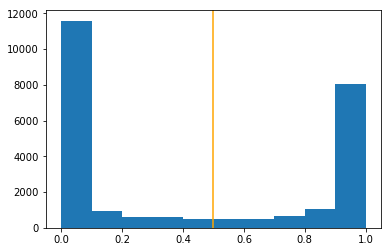

In [24]:
len(y_hat)
plt.hist(y_hat)
_=plt.axvline(x=0.5,color="orange")

In [25]:
#auc
roc_auc_score(y_valid,y_hat)

0.96025640639999998

In [26]:
y_hats=[]
for y in y_hat:
    y_hats.append(y[0])

result=pd.DataFrame({"y_hat":y_hats,"y":y_valid})
result.head(5)


,y,y_hat
0,1,0.994907
1,1,0.969526
2,1,0.734396
3,1,0.041151
4,1,0.997603


In [27]:
result[(result.y==0) & (result.y_hat>0.9)].head(10)

,y,y_hat
21,0,0.946156
105,0,0.901798
204,0,0.960411
240,0,0.957855
341,0,0.974741
419,0,0.934646
482,0,0.964092
489,0,0.944977
584,0,0.904422
822,0,0.943959


In [ ]:
#look at an incorrectly calssified example
print(' '.join(index_word[index] for index in x_train[21]))